In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special
import os.path
import pickle

%autosave 60

Autosaving every 60 seconds


## Generating Sequences

In [13]:
%%time
n_seq = 300000
#Sequences = generate_Sequences(n_seq)
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "rb" ) )

print_raw_file(Sequences, "../Text_files/file2.txt")
generate_newick_format("../Text_files/file2.txt")


[[     0      0]
 [     0      1]
 [     0      2]
 ...
 [ 13414 299997]
 [172896 299998]
 [ 89407 299999]]
CPU times: user 24.2 s, sys: 845 ms, total: 25 s
Wall time: 25.8 s


In [14]:
Sequences[8000].master_sequence, Sequences[8000].sequence, Sequences[8000].hamming_distance, Sequences[8000].energy_parent, Sequences[8000].energy, Sequences[8000].delta_energy


('aanndodpa', 'jkcnkkhpa', 6, -1.37, -1.36, 0.009999999999999981)

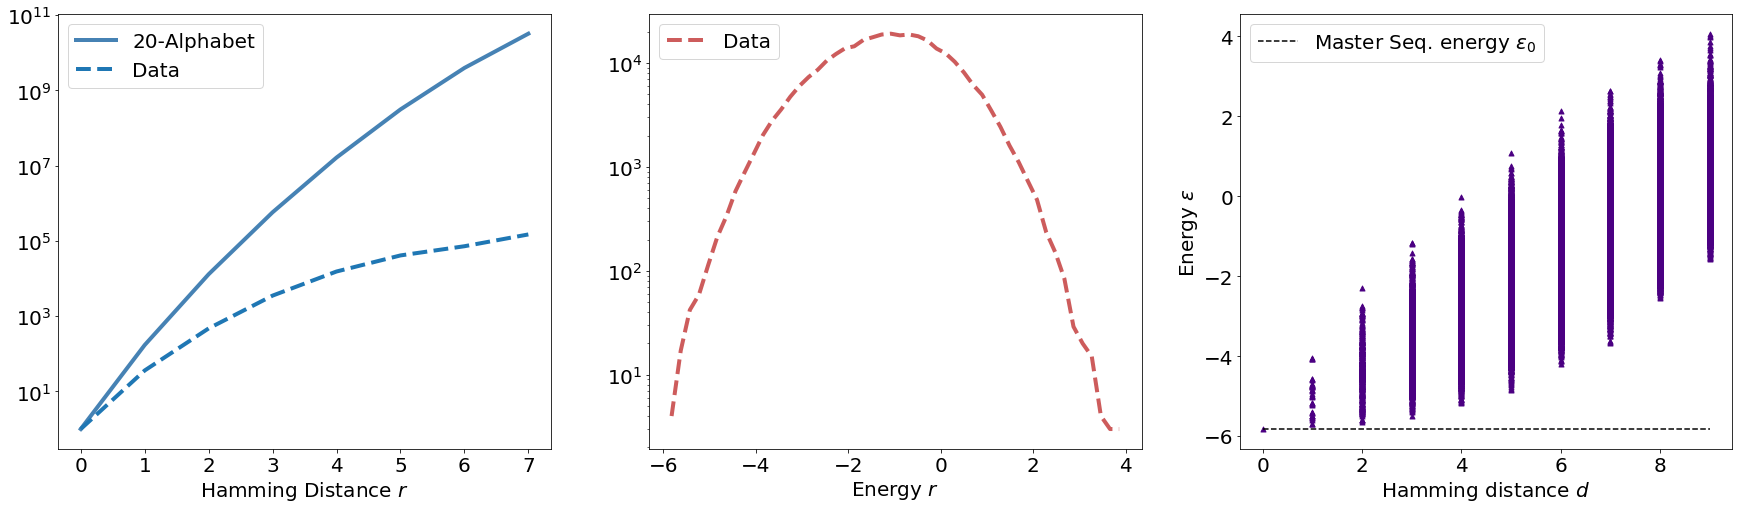

In [7]:
fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = np.array([])
for i in range(n_seq):
    distances = np.append(distances,Sequences[i].hamming_distance)
data_distances = np.histogram(distances, bins=range(int(max(distances))))

#ax[0].plot(data_distances[1][0:-1], scipy.special.comb(9, data_distances[1][0:-1]), linewidth = 4 , label = 'Binary')
ax[0].plot(data_distances[1][0:-1], scipy.special.comb(9, data_distances[1][0:-1])*((20-1)**data_distances[1][0:-1]), color = 'steelblue', linewidth = 4 , label = '20-Alphabet')
#ax[0].plot(data_distances[1][0:-1], scipy.special.comb(9, data_distances[1][0:-1])*((4-1)**data_distances[1][0:-1]), linewidth = 4 , label = '4-Alphabet')

#ax[0].plot(data_distances[1][0:-1], np.exp(4*data_distances[1][0:-1]), linewidth = 4, label = r'$e^{\lambda r}$')
ax[0].plot(data_distances[1][0:-1], data_distances[0], linewidth = 4, label = 'Data', linestyle = 'dashed')

ax[0].set_yscale('log')
#ax[0].set_ylim(1,1e8)
ax[0].set_xlabel(r'Hamming Distance $r$', fontsize = 20)
ax[0].set_ylabel(r'', fontsize = 20)
ax[0].tick_params(labelsize = 20)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(np.concatenate(([],handles)),np.concatenate(([],labels)), loc = 2, fontsize = 20)

#__________________________________________________________________________________________

energies = np.array([])
for i in range(n_seq):
    energies = np.append(energies,Sequences[i].energy)
data_energies = np.histogram(energies, bins=50)

ax[1].plot(data_energies[1][0:-1], data_energies[0], linewidth = 4, color = 'indianred', label = 'Data', linestyle = 'dashed')
ax[1].set_yscale('log')
#ax[1].set_ylim(1,1e10)
ax[1].set_xlabel(r'Energy $r$', fontsize = 20)
ax[1].set_ylabel(r'', fontsize = 20)
ax[1].tick_params(labelsize = 20)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(np.concatenate(([],handles)),np.concatenate(([],labels)), loc = 2, fontsize = 20)

#__________________________________________________________________________________________


ax[2].scatter(distances, energies, color = 'indigo', s = 25, marker = '^')
ax[2].hlines(energies[0],0,9, linestyle = 'dashed', label = r'Master Seq. energy $\epsilon_0$')
#ax[2].set_yscale('log')
#ax[2].set_ylim(1,1e10)
ax[2].set_xlabel(r'Hamming distance $d$', fontsize = 20)
ax[2].set_ylabel(r'Energy $\epsilon$', fontsize = 20)
ax[2].tick_params(labelsize = 20)
ax[2].legend(loc = 0, fontsize = 20)


## Stochastic Simulation

In [8]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 2
R=6
beta = 1
gamma = 1
T = 20000
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = 12)
Model.Gillespie()


CPU times: user 2min 41s, sys: 2min, total: 4min 42s
Wall time: 4min 54s


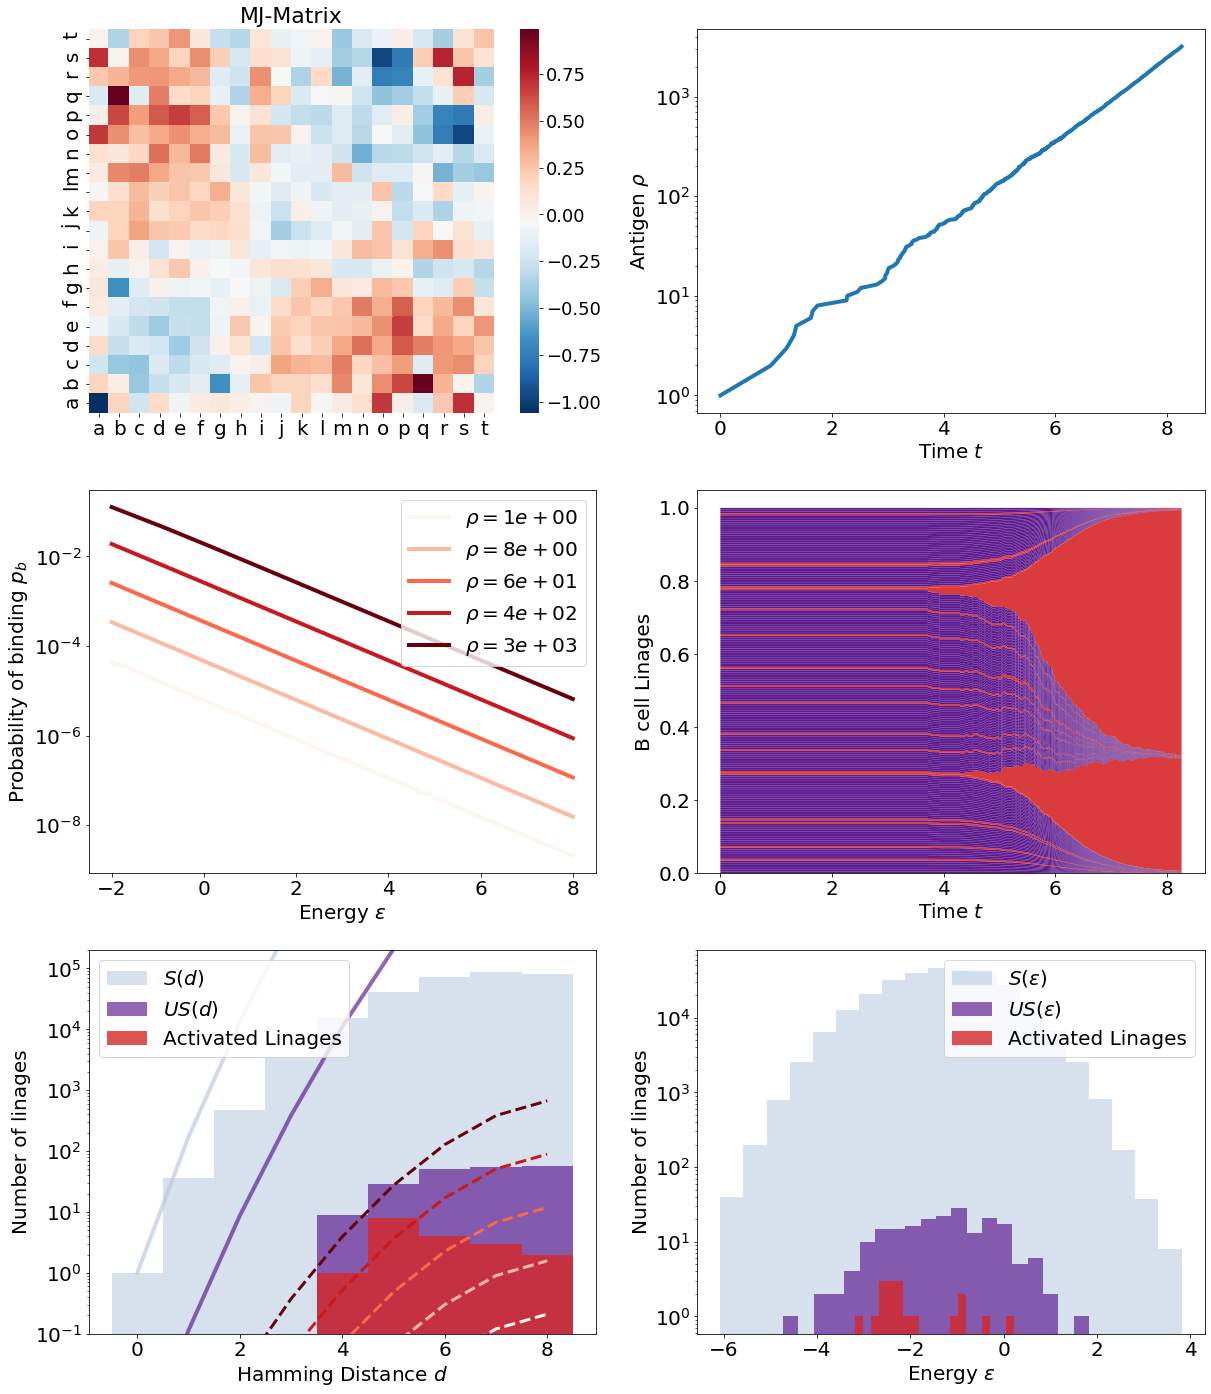

In [9]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

Model.plot_energy_matrix(ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))


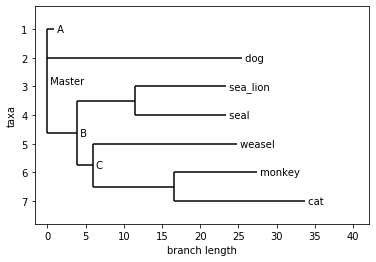

In [10]:
tree = Phylo.read(StringIO("Master(A():0.84600,B((sea_lion:11.99700, seal:12.00300):7.52973,C((monkey:10.85930,cat:17.14069):10.59201, weasel:18.87953):2.09460):3.87382,dog:25.46154):0"), "newick")
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

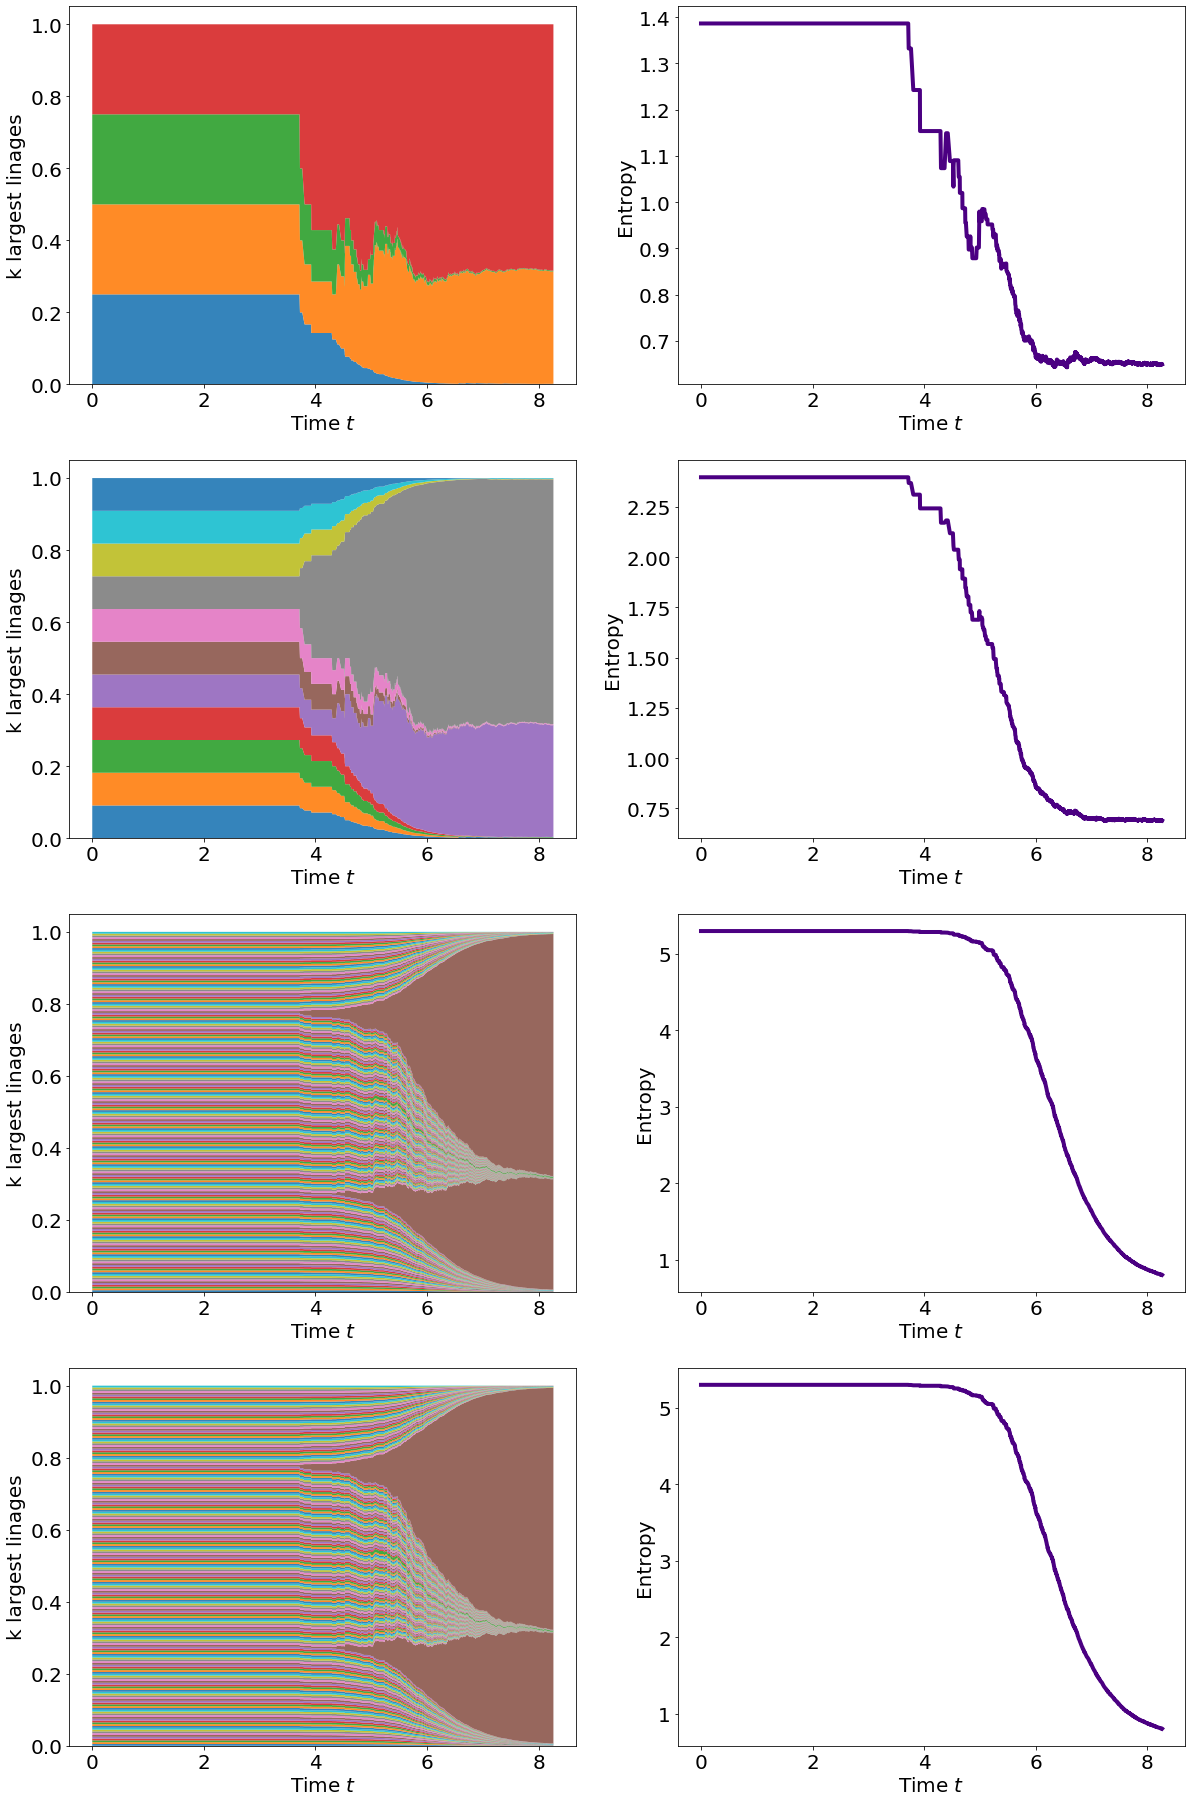

In [12]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

biggest_k_linages_freq = Model.plot_k_largest_linages(k=4, ax=ax[0,0])
Model.plot_entropy_k_largest_linages(k=4, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[0,1])

biggest_k_linages_freq = Model.plot_k_largest_linages(k=10, ax=ax[1,0])
Model.plot_entropy_k_largest_linages(k=10, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[1,1])

biggest_k_linages_freq = Model.plot_k_largest_linages(k=50, ax=ax[2,0])
Model.plot_entropy_k_largest_linages(k=50, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[2,1])

biggest_k_linages_freq = Model.plot_k_largest_linages(k=100, ax=ax[3,0])
Model.plot_entropy_k_largest_linages(k=100, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[3,1])

